# Self-Driving Car Engineer Nanodegree Term1
## Project 4 : Advanced Lane Finding
---

In this project, your goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car. The camera calibration images, test road images, and project videos are available in the [project repository](https://github.com/udacity/CarND-Advanced-Lane-Lines).

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/571/view) for this project.


The method of computing the calibration and undistortion is in [this repository](https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb).

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import re
%matplotlib inline

## Camera Calibration

### Extract object points and image points for camera calibration.

In [2]:
# prepare object points
nx = 9 # number of inner points in x
ny = 6 # number of inner points in y

# prepare object points, like (0, 0, 0), (1, 0, 0), (2, 0, 0) ..., (6, 5, 0)
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] #3d points in real world space
imgpoints = [] #2d points in image plane

# Make a list of calibration images
images = sorted(glob.glob('camera_cal/cali*.jpg'))

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    num = re.findall(r'\d+', fname)
    #print(str(num[0]))

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        plt.show()
        # Save jpg
        write_name = 'corners_found'+str(num[0])+'.jpg'
        cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)
    else:
        print("No corners detected: " + fname)

cv2.destroyAllWindows()

No corners detected: camera_cal/calibration1.jpg
No corners detected: camera_cal/calibration4.jpg
No corners detected: camera_cal/calibration5.jpg


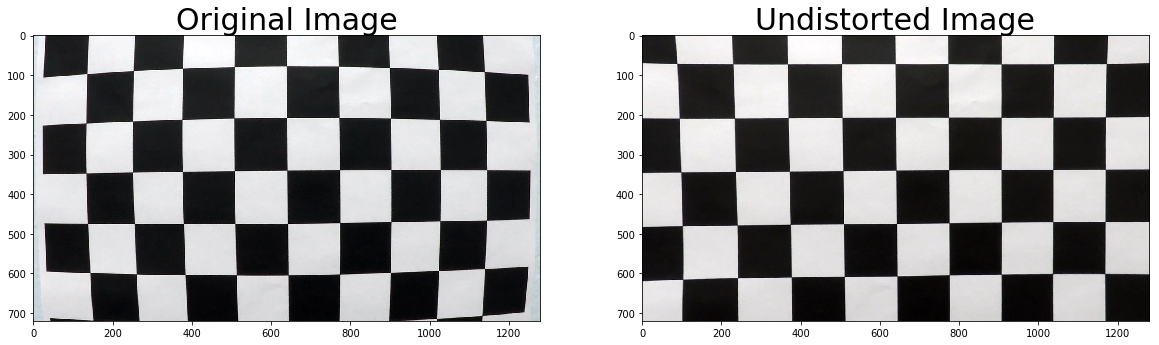

In [3]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[0], img.shape[1])

# convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
# Find chessboard corvers
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
# Drawing detected corners on an image
img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)


# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('test_undist.jpg',dst)
cv2.imwrite('test_dis.jpg', img)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

## Single image (pipeline)

### An example of distortion-corrected image.

In [4]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import re
import pickle
%matplotlib inline

with open('wide_dist_pickle.p', 'rb') as fp:
    dist_pickle = pickle.load(fp)
mtx, dst = dist_pickle['mtx'], dist_pickle['dist']

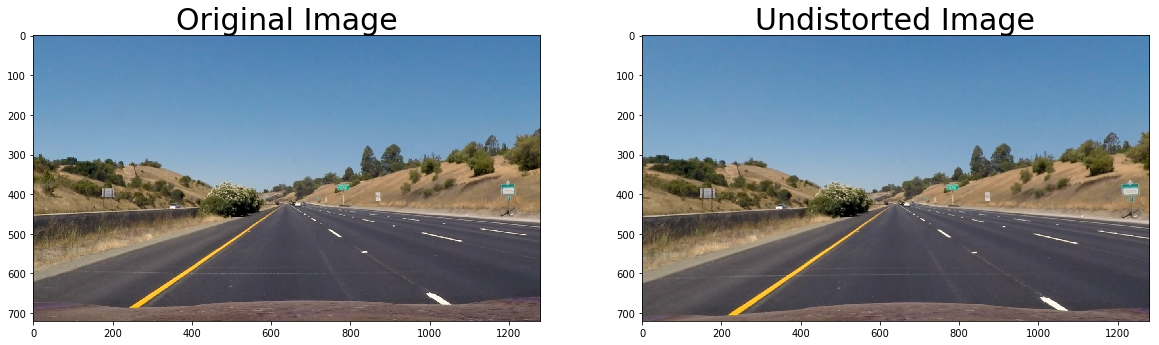

In [5]:
# Testing undistortion on an image
#img = cv2.imread('test_images/test5.jpg')
img = cv2.imread('test_images/straight_lines1.jpg')
img_size = (img.shape[0], img.shape[1])

# Converting to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Undistorting image
undst = cv2.undistort(img, mtx, dist, None, mtx)

# Saving jpg files
cv2.imwrite('road_undist.jpg',dst)
cv2.imwrite('road_dis.jpg', img)

# Converting BGR to RGB
undst_img = cv2.cvtColor(undst, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undst_img)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

In [6]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', sobel_kernel = 3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # isn't mpimg.imread() should use BGR2GRAY to convert to gray?
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>=thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return binary_output


# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0 ,1, ksize=sobel_kernel))
    
    # 3) Calculate the magnitude 
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*magnitude/np.max(magnitude))
    
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return binary_output


# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    directions = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(directions)
    binary_output[(directions>=thresh[0]) & (directions < thresh[1])] = 1 # Remove this line
    
    # 6) Return this mask as your binary_output image
    return binary_output


def color_threshold(img, thresh=(170, 255)):
    # Apply the following steps to img
    # 1) Convert to HLS: hue, lightness, saturation
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]  #lightness
    s_channel = hls[:,:,2]  #saturation
    
    # 2) Create a binary mask where color channel thresholds are met
    binary_output = np.zeros_like(s_channel)
    
    # 3) Reuturn this mask as your binary_output image
    binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1]) &(l_channel>=10)] = 1
    
    return binary_output

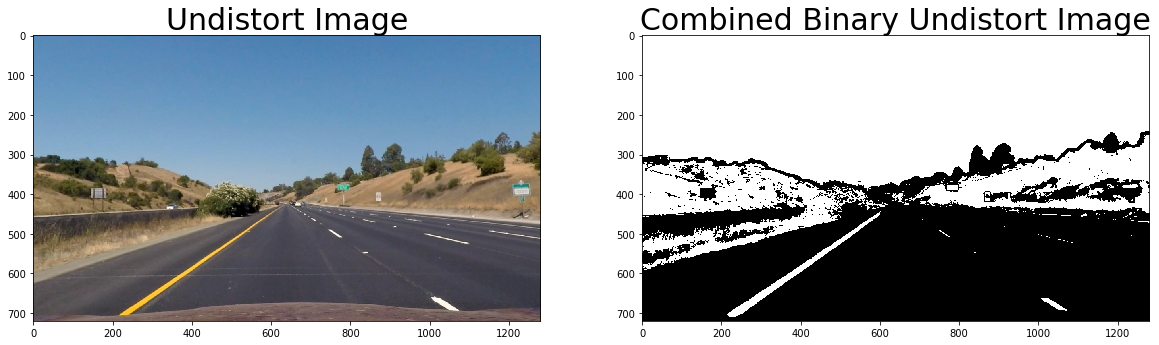

In [7]:
# test one image
image = undst_img

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
#gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(70, 100))
#grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
#mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
#dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/4))
color_binary = color_threshold(image, thresh=(60, 255))
combined = color_binary
#combined = np.zeros_like(dir_binary)
#combined[(((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))) | (color_binary == 1)] = 1

#combined2 = np.zeros_like(dir_binary)
#combined2[(gradx == 1)|(color_binary == 1)] = 1

#combined = color_binary
#combined = combined2

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Undistort Image', fontsize=30)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined Binary Undistort Image', fontsize=30)
plt.show()


#f2, (ax3, ax4) = plt.subplots(1,2, figsize =(20, 10))
#ax3.imshow(color_binary)
#ax3.set_title('Color binary')
#ax4.imshow(mag_binary)
#ax4.set_title('mag binary')

#f3, (ax5, ax6) = plt.subplots(1,2, figsize=(20, 10))
#ax5.imshow(gradx)
#ax5.set_title('gradx',fontsize=30)

#ax6.imshow(combined2, cmap='gray')

### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

Source points: 
 [[  578.           460.        ]
 [  193.33332825   720.        ]
 [ 1125.33337402   720.        ]
 [  705.           460.        ]]
Destination points: 
 [[ 320.    0.]
 [ 320.  715.]
 [ 960.  715.]
 [ 960.    0.]]


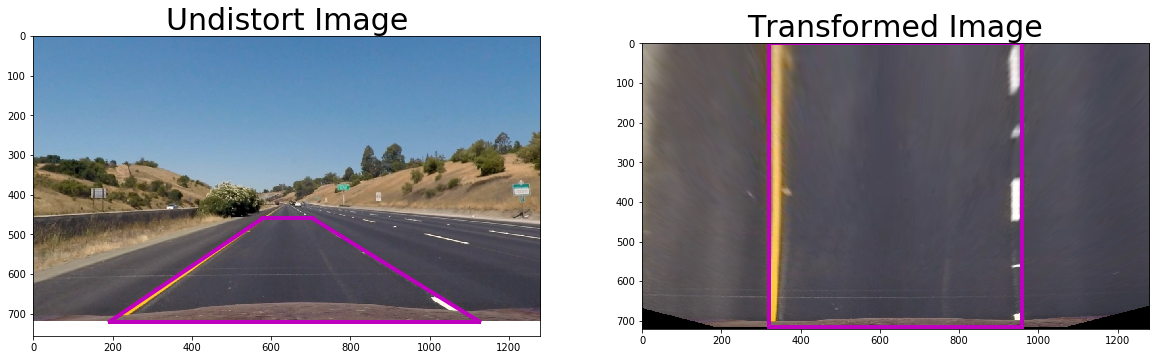

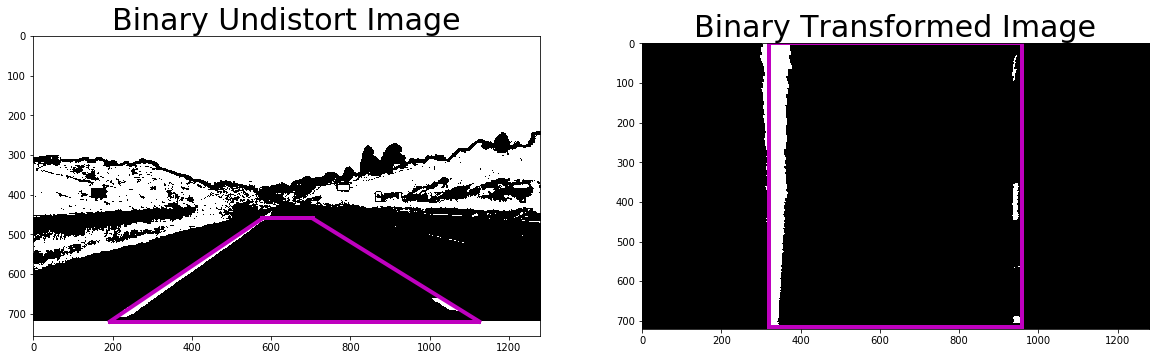

In [8]:
# image size
img_size = (image.shape[1], image.shape[0])

# Specify source points:
src_lt = [(img_size[0] / 2) - 62, img_size[1] / 2 + 100]
#src_lb = [((img_size[0] / 6) + 80), img_size[1]-70]
#src_rb = [(img_size[0] * 4 / 6) + 160, img_size[1]-70]
src_lb = [((img_size[0] / 6) - 20), img_size[1]]
src_rb = [(img_size[0] * 4 / 6) + 272, img_size[1]]
src_rt = [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]
src = np.float32([src_lt, src_lb, src_rb, src_rt])
print('Source points: \n', src)

# Sepcify destination points:
dst_lt = [(img_size[0]/4), 0]
dst_lb = [(img_size[0]/4), img_size[1]-5]
dst_rb = [(img_size[0]*3/4), img_size[1]-5]
dst_rt = [(img_size[0]*3/4), 0]
dst = np.float32([dst_lt, dst_lb, dst_rb, dst_rt])
print('Destination points: \n', dst)

# Compute the perspective transform, M, given source and destination points:
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

#Warp an image using the perspective transform, M:
#warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
binary_warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(image)
src_color = 'm'
lw = 4
ax1.set_title('Undistort Image', fontsize=30)
ax1.plot([src_lt[0], src_lb[0]], [src_lt[1], src_lb[1]],linewidth=lw, color=src_color)
ax1.plot([src_lb[0], src_rb[0]], [src_lb[1], src_rb[1]], linewidth=lw, color=src_color)
ax1.plot([src_rb[0], src_rt[0]], [src_rb[1], src_rt[1]], linewidth=lw, color=src_color)
ax1.plot([src_rt[0], src_lt[0]], [src_rt[1], src_lt[1]], linewidth=lw, color=src_color)
# ax1.line(src_lt, src_lb)
ax2.imshow(warped)
ax2.set_title('Transformed Image', fontsize=30)
dst_color = 'm'
ax2.plot([dst_lt[0], dst_lb[0]], [dst_lt[1], dst_lb[1]], linewidth=lw, color=dst_color)
ax2.plot([dst_lb[0], dst_rb[0]], [dst_lb[1], dst_rb[1]], linewidth=lw, color=dst_color)
ax2.plot([dst_rb[0], dst_rt[0]], [dst_rb[1], dst_rt[1]], linewidth=lw, color=dst_color)
ax2.plot([dst_rt[0], dst_lt[0]], [dst_rt[1], dst_lt[1]], linewidth=lw, color=dst_color)
plt.show()


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(combined, cmap='gray')
src_color = 'm'
ax1.set_title('Binary Undistort Image', fontsize=30)
ax1.plot([src_lt[0], src_lb[0]], [src_lt[1], src_lb[1]],linewidth=lw, color=src_color)
ax1.plot([src_lb[0], src_rb[0]], [src_lb[1], src_rb[1]], linewidth=lw, color=src_color)
ax1.plot([src_rb[0], src_rt[0]], [src_rb[1], src_rt[1]], linewidth=lw, color=src_color)
ax1.plot([src_rt[0], src_lt[0]], [src_rt[1], src_lt[1]], linewidth=lw, color=src_color)
# ax1.line(src_lt, src_lb)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Binary Transformed Image', fontsize=30)
dst_color = 'm'
ax2.plot([dst_lt[0], dst_lb[0]], [dst_lt[1], dst_lb[1]], linewidth=lw, color=dst_color)
ax2.plot([dst_lb[0], dst_rb[0]], [dst_lb[1], dst_rb[1]], linewidth=lw, color=dst_color)
ax2.plot([dst_rb[0], dst_rt[0]], [dst_rb[1], dst_rt[1]], linewidth=lw, color=dst_color)
ax2.plot([dst_rt[0], dst_lt[0]], [dst_rt[1], dst_lt[1]], linewidth=lw, color=dst_color)
plt.show()

### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

In [9]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[np.int32(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
#margin = 100
margin = 60  # 100 seems to too big so that it captures other shades
# Set minimum number of pixels found to recenter window
minpix = 30
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 4) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 4) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

1806.99736094 1655.49878478
719.0
[  2.76836448e-04  -4.16080092e-01   3.54264009e+02]

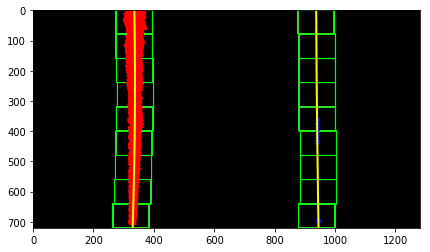

In [10]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
cv2.imwrite('out_img.jpg', out_img)
rec_img = cv2.imread('out_img.jpg')


plt.figure(figsize=(8, 4))
plt.imshow(rec_img)
plt.plot(left_fitx, ploty, color='yellow', linewidth=2)
plt.plot(right_fitx, ploty, color='yellow', linewidth=2)
plt.xlim(0, img_size[0])
plt.ylim(img_size[1], 0)
plt.show()


### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

In [11]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(round(left_curverad, 2), round(right_curverad, 2))
# Example values: 1926.74 1908.48

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

# Calculate the new radius of curvature
left_curverad = np.int(((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0]))
right_curverad = np.int(((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0]))

if left_curverad < right_curverad:
    avg_curverad = left_curverad
else:
    avg_curverad = right_curverad
# Now our radius of curvature is in meters
print("Radius of curvature: ", left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

# Calculate the position of the vehicle with respect to center
car_center_pix = img_size[0]/2
road_center_pix = leftx[0] + (rightx[0] - leftx[0])/2
diff_center_pix = car_center_pix - road_center_pix
diff_center_m = round(diff_center_pix * xm_per_pix,2)
print("Position of the vehicle with respect to center: ", diff_center_m, "m")

14660.74 61016.63
Radius of curvature:  4807 m 20032 m
Position of the vehicle with respect to center:  0.07 m


In [12]:
print(leftx.shape)
print(lefty.shape)
print(rightx.shape)
print(righty.shape)
print(left_fit_cr)
print(right_fit_cr)

(33750,)
(33750,)
(1770,)
(1770,)
[ -1.03997252e-04   2.12645396e-03   1.77266515e+00]
[  2.49591110e-05   6.19940956e-04   4.95507405e+00]


* 43730.27 144937.19
* Radius of curvature:  14358 m 47582 m
* Position of the vehicle with respect to center:  0.06 m

### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly

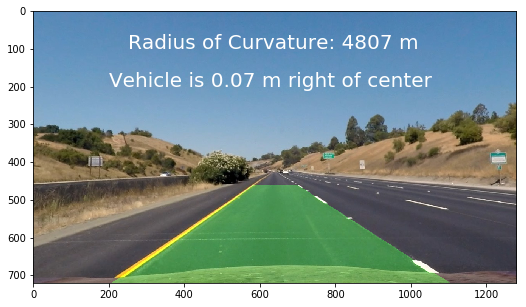

In [13]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right)).astype(np.int32)

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
#cv2.fillPoly(color_warp, pts, (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undst_img, 1, newwarp, 0.3, 0)
plt.figure(figsize=(10,5))
plt.imshow(result)
plt.text(250, 100, 'Radius of Curvature: '+ str(avg_curverad) + ' m', fontsize=20, color = 'w')
dir_string = ['m left of center', 'm right of center']
plt.text(200, 200, 'Vehicle is '+ str(np.abs(diff_center_m)) + ' ' + dir_string[diff_center_m > 0], fontsize=20, color = 'w')
plt.show()